# hodgkin–huxley model

In [60]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import ipywidgets as widgets
from cycler import cycler

# some plotting style parameters
plt.style.use(plt.style.available[20])
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['axes.grid'] = True
mpl.rcParams[ 'grid.linewidth'] = 0.5
mpl.rcParams['font.sans-serif'] = [ 'Arial']
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.prop_cycle'] = cycler('color', ['#ff7f00','#984ea3','#4daf4a'])


%matplotlib inline

Define the constants and the time step of ODE

# The 4 equations of the Hodgkin-Huxley model  

($V$: Membrane Potential)

* $C_M\displaystyle \frac{dV}{dt}=-g_{Na}\;\;(V-V_{Na})-g_k\;\;(V-V_K)-g_l\;\;(V-V_l)+I$   


($h$: Na Inactivation)  

* $\displaystyle \frac{dh}{dt}=\alpha_h{(V)}\;\;(1-h)-\beta_h(V)h$ 


($m$: Na Activation) 

* $\displaystyle \frac{dm}{dt}=\alpha_m{(V)}\;\;(1-m)-\beta_m(V)m$ 


($n$: K Activation)  

* $\displaystyle \frac{dn}{dt}=\alpha_n{(V)}\;\;(1-n)-\beta_n(V)n$ 

In [61]:
def dv(v, param, dt, par_dict):
    
    C_m = par_dict['C_m']
    G_Na = par_dict['G_Na']
    G_K = par_dict['G_K']
    G_L = par_dict['G_L']
    E_Na = par_dict['E_Na']
    E_K = par_dict['E_K']
    E_L = par_dict['E_L']
    
    
    
    
    h, m, n, i = param
    gna = G_Na * h * (m**3)
    gk = G_K * (n**4)
    gl = G_L
    ina = gna * (v - E_Na)
    ik = gk * (v - E_K)
    il = gl * (v - E_L)
    return (- ina - ik - il + i) * dt / C_m

def dh(h, param, dt, par_dict):
    v = param
    alph = 0.07 * np.exp(-v / 20)
    beth = 1. / (np.exp((30 - v) / 10) + 1)
    return (alph * (1 - h) - beth * h) * dt

def dm(m, param, dt, par_dict):
    v = param
    alpm = 0.1 * (25 - v) / (np.exp((25 - v) / 10) - 1)
    betm = 4. * np.exp(-v / 18)
    return (alpm * (1 - m) - betm * m) * dt

def dn(n, param, dt, par_dict):
    v = param
    alpn = 0.01 * (10 - v) / (np.exp((10 - v) / 10) - 1)
    betn = 0.125 * np.exp(-v / 80)
    return (alpn * (1 - n) - betn * n) * dt

Update the variables by Runge–Kutta method

In [62]:
def rk4(f, y, param, dt, par_dict):
    k1 = f(y, param, dt, par_dict)
    k2 = f(y + dt * k1 * 0.5, param, dt, par_dict)
    k3 = f(y + dt * k2 * 0.5, param, dt, par_dict)
    k4 = f(y + dt * k3, param, dt, par_dict)
    return (k1 + 2*k2 + 2*k3 + k4) / 6

def update(v, m, h, n, i, dt, par_dict):
    v += rk4(dv, v, (h, m, n, i), dt, par_dict)
    m += rk4(dm, m, v, dt, par_dict)
    h += rk4(dh, h, v, dt, par_dict)
    n += rk4(dn, n, v, dt, par_dict)
    return v, m, h, n

Initialize the variables

In [63]:
def run_simulation(
    ### simulation parameters ###
   
    dt = 0.01,      # time step (ms)
    T = 70,       # total running time (ms)
    
    
    ### model paramters ###
    C_m = 1.,       # membrane capacitance (micro F/cm**2)
    
    # Sodium Channel
    G_Na = 120.,    # max Na conductance (mS/cm**2)
    E_Na = 115.,    # Na reversal potential (mV)
    
    # Kalium Channel
    G_K = 40.,      # max K conductance (mS/cm**2)
    E_K = -12.0,    # K reversal potential (mV)
    
    # Leak current    
    G_L = 0.24,     # max leak onductance (mS/cm**2)
    E_L = 10.613,   # leak potential (mV)
    
    flag = 'spike'
    ):
    
    par_dict = dict(
    C_m = C_m,
    G_Na = G_Na,
    E_Na = E_Na,
    G_K  = G_K,
    E_K  = E_K,
    G_L  = G_L,
    E_L  = E_L,
    )
    # initialize the simulation parameters
    V_m = 0 # membrane potential (mV)
    m_Na = 0 # Na channel activation (dimensionless)
    h_Na = 0 # Na channel inactivation (dimensionless)
    n_K = 0 # K channel activation (dimensionless)

    # total membrane current (microA/cm**2) for the time of the simulation
    
    I_input = np.array([0] * int(T/dt))
    if flag == 'spike':
        I_input[1500:1800] = 10
    if flag == 'burst':
        I_input[1500:] = 10
    if flag == 'refractory':
         I_input[1500:1800] = 10
         I_input[2100:2400] = 10
         I_input[2700:3000] = 10
    Time = [ii*dt for ii in range(int(T/dt))]


    result_V_m, result_m_Na, result_h_Na, result_n_K = ([] for i in range(4))
    for t in range(int(100 // dt)):
        V_m, m_Na, h_Na, n_K = update(v=V_m, m=m_Na, h=h_Na, n=n_K, i=0, dt=dt, par_dict = par_dict)
    for t in range(len(I_input)):
        V_m, m_Na, h_Na, n_K = update(v=V_m, m=m_Na, h=h_Na, n=n_K, i=I_input[t], dt=dt, par_dict = par_dict)
        result_V_m.append(V_m)
        result_m_Na.append(m_Na)
        result_h_Na.append(h_Na)
        result_n_K.append(n_K)
    return result_V_m, result_m_Na, result_h_Na, result_n_K, I_input, Time

Define membrane current

In [64]:
def plot_current(Time, Current):
    plt.subplots(figsize = [12,5])
    plt.xlabel('$t$ (ms)')
    plt.ylabel('$I$ $\mathrm{(\mu A/cm^2)}$')
    # plt.xlim(-1, 30)
    plt.ylim(-2, 12)
    plt.plot(Time, Current)
    plt.title('Input Current $I$')
    plt.savefig('1current.png', dpi=144)
    
def plot_membrane_potential(Time, Voltage):

    plt.subplots(figsize = [12,5])
    plt.xlabel('$t$ (ms)')
    plt.ylabel('$V$ (mV)')
    plt.ylim(-20, 120)
    plt.plot(Time, Voltage, color = '#bd0026')
    title = plt.title('Membrane Potential $V$')

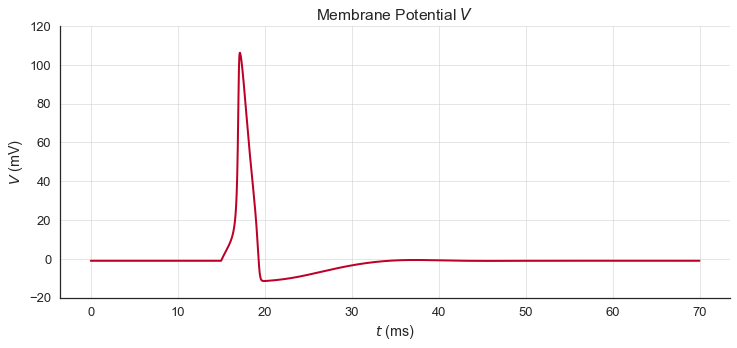

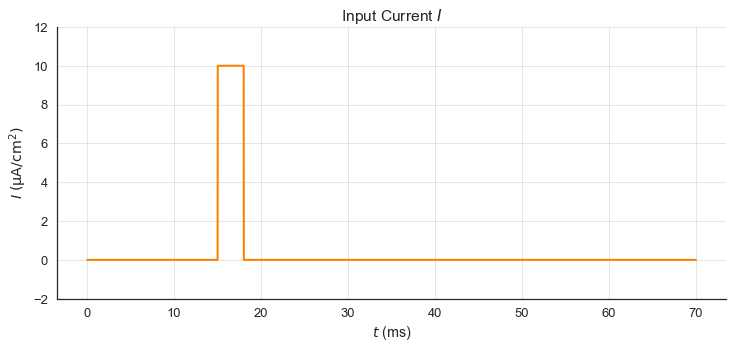

In [65]:
Voltage,m,h,n,I,Time = run_simulation()

plot_membrane_potential(Time = Time, Voltage = Voltage)
plot_current(Time = Time, Current = I)



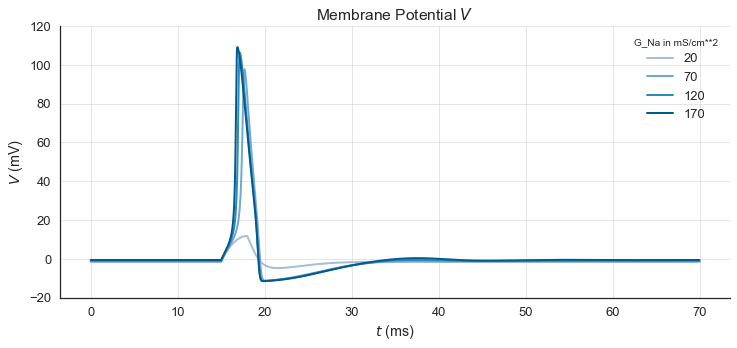

In [66]:
fig, ax = plt.subplots(figsize = [12,5])
colors = ['#a6bddb','#74a9cf','#2b8cbe','#045a8d']
for color, G_Na in zip(colors,[20,70, 120, 170]):
    V_membrane,_,_,_,_,Time = run_simulation(G_Na = G_Na)
    ax.plot(Time, V_membrane, color = color, label = f"{G_Na}")
    
    
ax.set_xlabel('$t$ (ms)')
ax.set_ylabel('$V$ (mV)')
ax.set_ylim(-20, 120)
title = plt.title('Membrane Potential $V$')
ax.legend(title = "G_Na in mS/cm**2" )

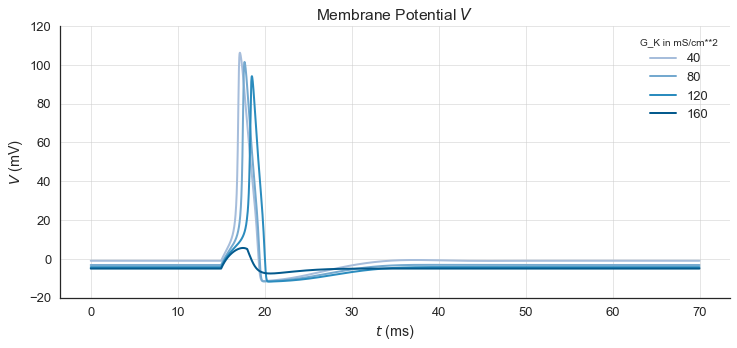

In [67]:
fig, ax = plt.subplots(figsize = [12,5])
colors = ['#a6bddb','#74a9cf','#2b8cbe','#045a8d']
for color, G_K in zip(colors,[40,80, 120, 160]):
    V_membrane,_,_,_,_,Time = run_simulation(G_K = G_K)
    ax.plot(Time, V_membrane, color = color, label = f"{G_K}")
    
    
ax.set_xlabel('$t$ (ms)')
ax.set_ylabel('$V$ (mV)')
ax.set_ylim(-20, 120)
title = plt.title('Membrane Potential $V$')
ax.legend(title = "G_K in mS/cm**2" )

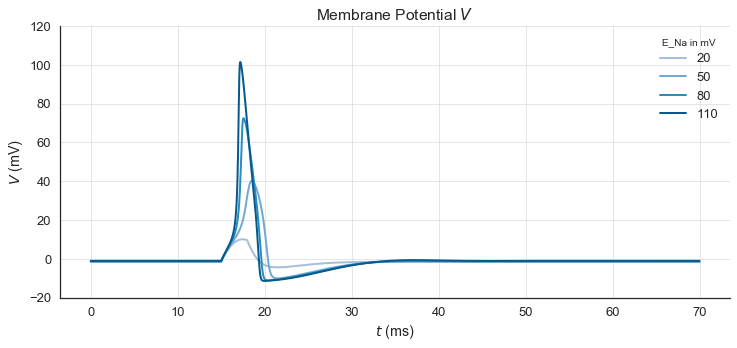

In [68]:
fig, ax = plt.subplots(figsize = [12,5])
colors = ['#a6bddb','#74a9cf','#2b8cbe','#045a8d']
for color, E_Na in zip(colors,[20,50, 80, 110]):
    V_membrane,_,_,_,_,Time = run_simulation(E_Na = E_Na)
    ax.plot(Time, V_membrane, color = color, label = f"{E_Na}")
    
    
ax.set_xlabel('$t$ (ms)')
ax.set_ylabel('$V$ (mV)')
ax.set_ylim(-20, 120)
title = plt.title('Membrane Potential $V$')
ax.legend(title = "E_Na in mV" )

Each channel activation

Text(0.5, 1.0, 'Ion Channel Activation')

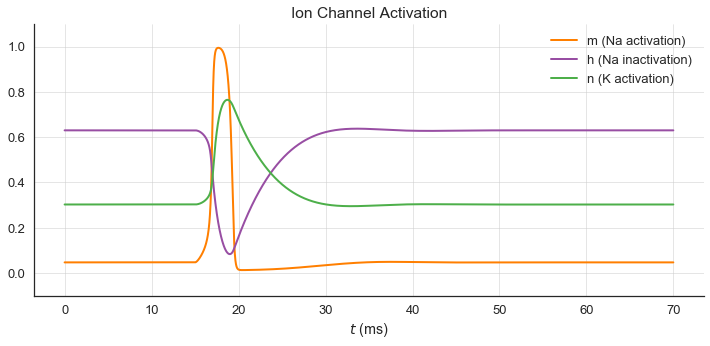

In [69]:
fig, ax = plt.subplots(figsize = [12,5])
plt.xlabel('$t$ (ms)')
plt.ylim(-0.1, 1.1)
plt.plot(Time, m)
plt.plot(Time, h)
plt.plot(Time, n)
plt.legend(['m (Na activation)', 'h (Na inactivation)',
            'n (K activation)'], bbox_to_anchor=(1, 1), framealpha=1)
plt.title('Ion Channel Activation')

## Electrical Bursting

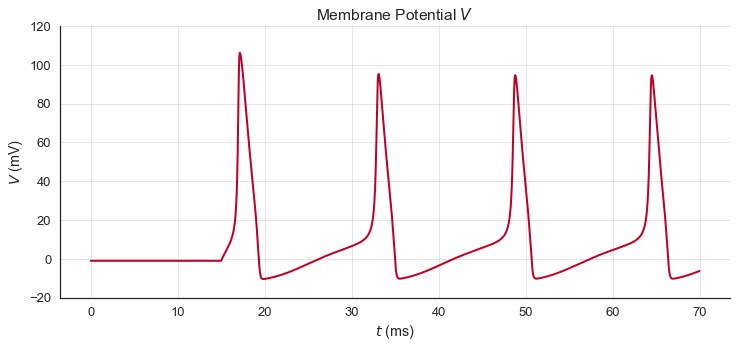

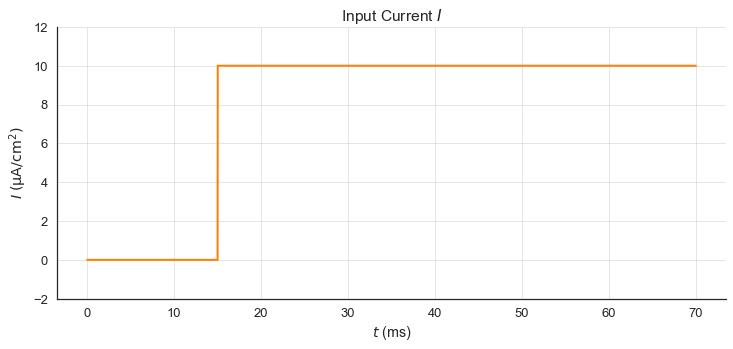

In [70]:
Voltage_burst,m_burst,h_burst,n_burst,I_burst,Time_burst = run_simulation(flag = 'burst')

plot_membrane_potential(Time = Time_burst, Voltage = Voltage_burst)
plot_current(Time = Time_burst, Current = I_burst)

Text(0.5, 1.0, 'Ion Channel Activation')

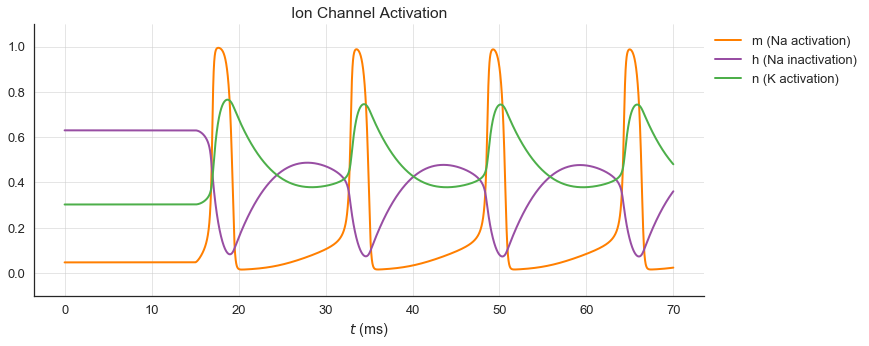

In [71]:
fig, ax = plt.subplots(figsize = [12,5])
plt.xlabel('$t$ (ms)')
plt.ylim(-0.1, 1.1)
plt.plot(Time_burst, m_burst)
plt.plot(Time_burst, h_burst)
plt.plot(Time_burst, n_burst)
plt.legend(['m (Na activation)', 'h (Na inactivation)',
            'n (K activation)'], bbox_to_anchor=(1, 1), framealpha=1)
plt.title('Ion Channel Activation')

## Refractory Period

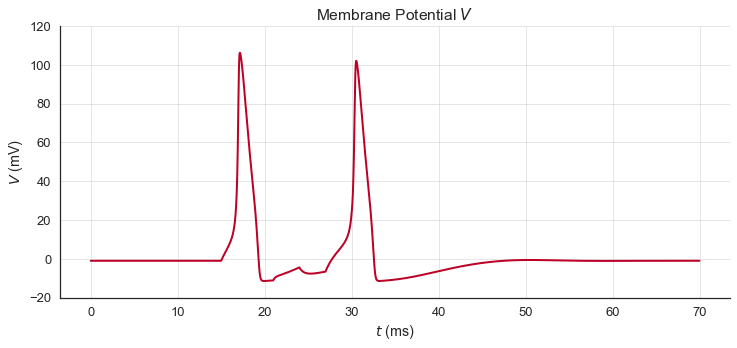

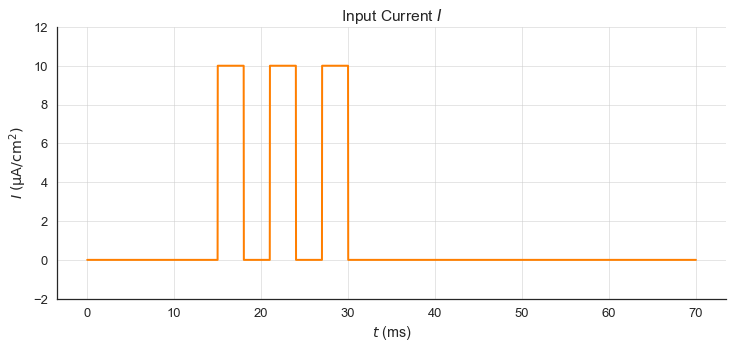

In [72]:
Voltage_refractory,m_refractory,h_refractory,n_refractory,I_refractory,Time_refractory = run_simulation(
    flag = 'refractory'
)

plot_membrane_potential(Time = Time_refractory, Voltage = Voltage_refractory)
plot_current(Time = Time_refractory, Current = I_refractory)

Text(0.5, 1.0, 'Ion Channel Activation')

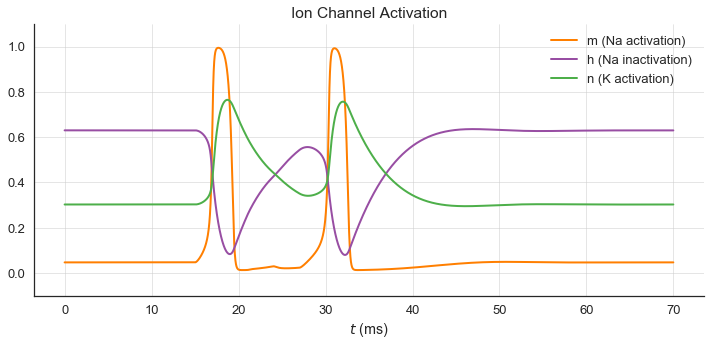

In [73]:
fig, ax = plt.subplots(figsize = [12,5])
plt.xlabel('$t$ (ms)')
plt.ylim(-0.1, 1.1)
plt.plot(Time_refractory, m_refractory)
plt.plot(Time_refractory, h_refractory)
plt.plot(Time_refractory, n_refractory)
plt.legend(['m (Na activation)', 'h (Na inactivation)',
            'n (K activation)'], bbox_to_anchor=(1, 1), framealpha=1)
plt.title('Ion Channel Activation')